# Fine Mapping

I want to take the significant eQTL variants and functionally annotate them
to come up with a list of variants that might be causal. There is a lot of
functional data for the H1-hESC line that I can use along with data from
other places.

In [1]:
import copy
import cPickle
import glob
import os
import random
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'fine_mapping'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls02', 'qvalues.tsv')
secondary_qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants_single.tsv')
lead_variants_single = pd.read_table(fn, index_col=0)
lead_variants_single_f = lead_variants_single[lead_variants_single.perm_sig]

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'gene_variant_pairs.tsv')
gene_variants = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

ensg = pd.Series(gene_info.index, index=[x.split('.')[0] for x in gene_info.index])

fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'cnv_gene_variants.pickle')
cnv_gv = pd.read_pickle(fn)

In [3]:
# ASE results.
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info_full = pd.read_table(fn, index_col=0)
motif_info_full['target'] = [x.split('_')[0] for x in motif_info_full.index]
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
motif_info['target'] = [x.split('_')[0] for x in motif_info.index]

I'll drop CNVs since they likely act through different mechanisms than I'm considering here.

In [5]:
n = gene_variants.shape[0]
print('{:,} total associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV, indels, and CNVs with significant associations.'.format(n))

256,156 total associations.
198,221 total distinct SNV, indels, and CNVs with significant associations.


In [6]:
gene_variants = gene_variants[gene_variants.variant_type != 'cnv']

## Predicted NMD

I'll use the snpEff annotation of the WGS to look for predicted NMD. I'd like to
see if any of the significant variants are predicted to cause NMD for the eQTL
gene.

If snpEff predicts NMD for a gene, the annotation looks like

    PITRM1|ENSG00000107959|11|0.27
    
This means that PITRM1 has 11 transcripts and 27% of them are predicted to have NMD.

In [7]:
fns = glob.glob('/projects/CARDIPS/pipeline/WGS/mergedVCF/annotation/vcf/*snpeff.vcf.gz')
fns = [x for x in fns if len(re.findall('chr\d{1,2}', x)) > 0]
fns = pd.Series(fns, index=[re.findall('chr\d{1,2}', x)[0] for x in fns])

for vcf in fns.values:
    out = os.path.join(private_outdir, os.path.split(vcf)[1].replace('.vcf.gz', '_nmd.vcf'))
    if not os.path.exists(out):
        !zcat {vcf} | java -jar /software/snpEff_v4_1l_core/SnpSift.jar filter "NMD[*]" > {out}

In [8]:
fns = glob.glob(os.path.join(private_outdir, '*_nmd.vcf'))
variants = []
nmd = []
for fn in fns:
    vcf_reader = pyvcf.Reader(open(fn))
    for r in vcf_reader:
        variants.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS))
        nmd.append(r.INFO['NMD'])
ind = []
vals = []
for i, v in enumerate(variants):
    r = nmd[i]
    for n in r:
        gene_name, gene_id, num_t, per_t = n.strip(')').split('|')
        ind.append(v + ':' + ensg[gene_id])
        vals.append([int(num_t), float(per_t)])
nmd = pd.DataFrame(vals, index=ind, columns=['nmd_num_transcripts', 'nmd_percent_transcripts_nmd'])

In [9]:
tdf = nmd.ix[set(nmd.index) & set(gene_variants.index)]

In [10]:
gene_variants = gene_variants.join(tdf)

In [11]:
gene_variants['nmd'] = False
gene_variants.ix[gene_variants.dropna(subset=['nmd_num_transcripts']).index, 'nmd'] = True

In [12]:
g = set(gene_variants.ix[gene_variants.nmd, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_nmd_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_nmd_variant.isnull(), 'gene_has_nmd_variant'] = False

## Exons, UTRs, and Promoters

I'll annotate whether variants fall in exons, UTRs or promoters for their significant
genes.

In [13]:
gene_variants_bt = pbt.BedTool('\n'.join(set(gene_variants.apply(lambda x: '{}\t{}\t{}'.format(
                    x['chrom'], x['start'], x['end']), axis=1))), from_string=True)
gene_variants_bt = gene_variants_bt.sort()

In [14]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
utrs = pbt.BedTool(cpy.gencode_utr_bed)
promoters = pbt.BedTool(cpy.gencode_promoter_bed)

In [15]:
res = gene_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['exonic_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'exonic_same_gene'] = True

df['exonic'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['exonic']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.exonic.isnull(), 'exonic'] = False

In [16]:
g = set(gene_variants.ix[gene_variants.exonic, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_variant.isnull(), 'gene_has_exonic_variant'] = False

g = set(gene_variants.ix[gene_variants.exonic_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_same_gene_variant.isnull(), 'gene_has_exonic_same_gene_variant'] = False

In [17]:
res = gene_variants_bt.intersect(utrs, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['utr_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'utr_same_gene'] = True

df['utr'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['utr']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.utr.isnull(), 'utr'] = False

In [18]:
res = gene_variants_bt.intersect(promoters, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart.apply(lambda x: x.split('_')[0])].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['promoter_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'promoter_same_gene'] = True

df['promoter'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['promoter']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.promoter.isnull(), 'promoter'] = False

In [19]:
g = set(gene_variants.ix[gene_variants.utr, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_variant.isnull(), 'gene_has_utr_variant'] = False

g = set(gene_variants.ix[gene_variants.utr_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_same_gene_variant.isnull(), 
                'gene_has_utr_same_gene_variant'] = False

g = set(gene_variants.ix[gene_variants.promoter_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_promoter_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_promoter_same_gene_variant.isnull(), 
                'gene_has_promoter_same_gene_variant'] = False

## Maurano et al. 2015 Data

I'm going to grab some data from [Maurano *et al.* 2015](http://www.nature.com/ng/journal/v47/n12/full/ng.3432.html).
The zip file seems to be corrupted. I was able to manually download on my mac 
and decompress it using Arhcive Utility but I couldn't get it work from the
command line so that this has to be downloaded by hand.

In [20]:
# This has all of the variants tested for imbalance and their significance.
maurano_res = pd.read_table('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S5.txt')
# This has SNVs from dbSNP 138 predicted to affect TF binding.
fn = os.path.join(private_outdir, 'ng.3432-S7')
if not os.path.exists(fn):
    print('Download ng.3432-S7, decompress, and add to private_outdir.')
    print('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S7.zip')
else:
    maurano_tf_disrupt = pd.read_table(fn)

In [21]:
se = maurano_res.chromEnd - maurano_res.chromStart
se[se > 1].shape

(0,)

The Maurano results are all SNVs.

In [22]:
print(len(set(maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + '-' + 
              maurano_res.chromEnd.astype(str))))
print(maurano_res.shape[0])

362284
362284


In [23]:
maurano_res.index = (maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + 
                     '-' + maurano_res.chromEnd.astype(str))

The Maurano results are all unique variants.

In [24]:
maurano_res.head(1)

,chrom,chromStart,chromEnd,rs,numhets,allele.1,readsA,allele.2,readsB,totalReads,pctRef,q.value,significance.level
chr1:752720-752721,chr1,752720,752721,snp5,33,G,1583,A,1454,3037,0.479,0.0912,not_imbalanced


It seems that the Maurano data is in zero-based coordinates.

In [25]:
maurano_res.columns = ['{}_maurano'.format(c) for c in maurano_res.columns]
gene_variants = gene_variants.merge(maurano_res, left_on='location', right_index=True, how='left')
gene_variants = gene_variants.drop(['chrom_maurano', 'chromStart_maurano', 'chromEnd_maurano'], axis=1)

I'll also add in the predicted TF disruptions.

In [26]:
maurano_tf_disrupt.columns = ['{}_maurano_tf'.format(x) for x in maurano_tf_disrupt.columns]
maurano_tf_disrupt.index = (maurano_tf_disrupt.chrom_maurano_tf + ':' +
                            maurano_tf_disrupt.snpChromStart_maurano_tf.astype(str) + 
                            '-' + maurano_tf_disrupt.snpChromEnd_maurano_tf.astype(str))
gene_variants = gene_variants.merge(maurano_tf_disrupt, left_on='location', 
                                  right_index=True, how='left')

In [27]:
gene_variants = gene_variants.drop(['chrom_maurano_tf', 'snpChromStart_maurano_tf', 
                                    'snpChromEnd_maurano_tf'], axis=1)

## Roadmap DNase

In [28]:
out = os.path.join(outdir, 'roadmap_dnase.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    df = pd.DataFrame(False, index=set(gene_variants.location), columns=lines)
    for url in urls:
        line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values, line] = True
    df = df.ix[:, df.sum() > 0]
    df.columns = [c.replace(' Cell Line', '').replace(' ', '_') + '_roadmap_dnase' for c in df.columns]
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE DNase

In [29]:
out = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    bs_types = ['stem cell', 'induced pluripotent stem cell line']
    encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

    cols = (encode_dnase.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC')) + 
            '_' + encode_dnase.index + '_dnase')
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=cols)
    encode_dnase['col'] = cols
    for i in encode_dnase.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_dnase.ix[i, 'col']] = True
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/pandas/computation/expressions.py:71: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  return op(a, b)


## ENCODE Transcription Factor ChIP-Seq

In [30]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
s = set(motif_info.tf) & set(encode_tf_chip_seq.target)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in s)]

In [31]:
out = os.path.join(outdir, 'encode_tf_chip_seq.tsv')
if not os.path.exists(out):
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=encode_tf_chip_seq.target.values)
    for i in encode_tf_chip_seq.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_tf_chip_seq.ix[i, 'target']] = True
    
    peak_overlap = df
    peak_overlap.to_csv(out, sep='\t')
else:
    peak_overlap = pd.read_table(out, index_col=0)

#gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

In [32]:
n = sum(peak_overlap.sum(axis=1) > 0)
print('{:,} of {:,} variants overlap at least one peak.'.format(n, peak_overlap.shape[0]))

8,050 of 197,673 variants overlap at least one peak.


## TF Motif Disruption

I'd like to identify variants that overlap a binding site for a transcription
factor and also disrupt a motif for that TF.

Things get a bit confusing here for a number of reasons. ChIP-seq experiments
are performed on specific proteins. Sometimes these proteins have the same name as
the transcription factor like SRF for instance. But sometimes the protein that 
is pulled down is part of a complex. For instance, ChIP-seq experiments for 
JUND, JUN, FOSL1, and others all target the transcription factor AP1 since these
proteins are subunits of AP1.

Another complication is that the motifs discovered by [Kheradpour et al.](http://nar.oxfordjournals.org/content/42/5/2976.full.pdf)
do not always correspond to the particular transcription factor the motif is named after. 
For instance, 20 different
"factor groups" have motifs that match the TPA DNA response element (TRE) motif.
For instance, AP1_disc3 matches the TRE motif. This could happen for a number of reasons
(outlined in the paper) such as the two TF's cobind or actually both use the motif etc.

For my purposes here, I need to make a few decisions. Let's use JUND/AP1 as an example.
There is an ENCODE experiment for JUND. There are also motifs discovered using JUND
ChIP-seq data. However, the motifs that are found under JUND peaks are assigned to
AP1 since that's the TF. So let's say we 
have a variant that overlaps a JUND peak from ENCODE. Should I test all AP1 motifs for
disruption, even if they were discovered in a different ChIP-seq data set (like from FOSL1)?
Testing all AP1 motifs also means that I'm testing motifs for other TFs (like AP1_disc3 which
is actually the motif for TRE as they mention in the paper). Looking at the data on 
http://compbio.mit.edu/encode-motifs/ for AP1, this seems to be unavoidable. Few motifs
are unique to AP1, and those that are unique have much weaker enrichment in the ChIP-seq
peaks. 

I think for my purposes here, I'll be inclusive about testing motifs. A disrupted motif
is evidence of some kind of effect.

In [33]:
encode_chip_seq[encode_chip_seq.target == 'TATA']

,cell_type,narrowPeak_accession,narrowPeak_url,target,target_type


In [34]:
t = motif_info[motif_info.tf.apply(lambda x: x in encode_chip_seq.target.values)]
motif_info = motif_info[motif_info.target.apply(lambda x: x in t.target.values)]

In [35]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = peak_overlap.copy(deep=True)
se = pd.Series(dict(zip(motif_info.tf, motif_info.target)))
tdf.columns = [se[x] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_overlap = pd.DataFrame(d)

In [165]:
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));

Cluster has 250 engines.
importing cdpybio on engine(s)
importing cardipspy on engine(s)


In [36]:
out = os.path.join(outdir, 'motif_diffs.tsv')
if not os.path.exists(out):
    tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]
    tdf = tdf.ix[tf_overlap_yes.index]

    d = {}
    for i in tf_overlap_yes.index:
        d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
    se = pd.Series(d)
    se = se[tdf.index]
    target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
    tdf['motifs'] = se.apply(lambda x: list(target_to_motif[x]))
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));
    
#     matrices_f = {k:matrices[k] for k in motif_info.index}
#     dview.push(dict(matrices_f=matrices_f));
    
#     res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
#         i, tdf.ix[i, 'ref'], tdf.ix[i, 'alt'], cpy.hg19, 
#         matrices_f), tdf.index)
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            i, tdf.ix[i, 'ref'], tdf.ix[i, 'alt'], cpy.hg19, 
            {k:matrices[k] for k in tdf.ix[i, 'motifs']}), tdf.index)
    motif_d = pd.DataFrame(index=tdf.index, columns=motif_info.index)
    a = []
    b = []
    for i,p in enumerate(tdf.index):
        if res[i].shape[0] > 0:
            a.append(p)
            b.append(res[i])
    d = dict(zip(a,b))
    p = pd.Panel(d)
    motif_d = p.ix[:, :, 'score_diff'].T
    motif_d.to_csv(out, sep='\t')
else:
    motif_d = pd.read_table(out, index_col=0)

Cluster has 250 engines.
importing cdpybio on engine(s)
importing cardipspy on engine(s)


For `motif_d`, the value is reference score minus alternate score. So a positive
value means the reference matched the motif better.

I'm not sure what score difference constitutes a disruption. Let's
take a look at the distribution of differences.

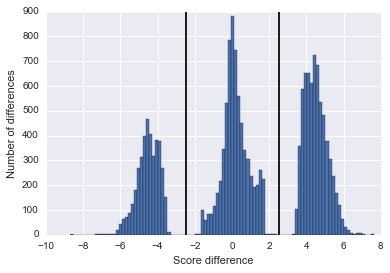

In [38]:
pd.Series(motif_d.values.flatten()).dropna().hist(bins=100)
ymin, ymax = plt.ylim()
plt.vlines(-2.5, ymin, ymax)
plt.vlines(2.5, ymin, ymax)
plt.ylabel('Number of differences')
plt.xlabel('Score difference');

It seems that a score difference greater than 2.5 in magnitude probably
represents a pretty big effect. I'll say these are disruptions.

In [39]:
motif_disrupt = motif_d.abs() >= 2.5
motif_disrupt = motif_disrupt[motif_disrupt.sum(axis=1) > 0]
motif_disrupt.to_csv(os.path.join(outdir, 'motif_disruption.tsv'), sep='\t')
#motif_disrupt.columns = ['{}_motif_disrupted'.format(x) for x in motif_disrupt.columns]
#gene_variants = gene_variants.merge(motif_disrupt, left_on='location', right_index=True, how='left')

In [40]:
print('{:,} variants disrupt a motif.'.format(motif_disrupt.shape[0]))

3,225 variants disrupt a motif.


In [41]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = motif_disrupt.copy(deep=True)
tdf.columns = [motif_info_full.ix[x, 'target'] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_disrupt = pd.DataFrame(d)
tf_disrupt.to_csv(os.path.join(outdir, 'tf_disruption.tsv'), sep='\t')

In [42]:
t = pd.DataFrame([tf_disrupt.index], index=['location']).T
t['tf_disrupt'] = True
gene_variants = gene_variants.merge(t, how='outer')
gene_variants.ix[gene_variants['tf_disrupt'].isnull(), 'tf_disrupt'] = False

In [43]:
t = pd.DataFrame([tf_overlap[tf_overlap.sum(axis=1) > 0].index], index=['location']).T
t['tf_overlap'] = True
gene_variants = gene_variants.merge(t, how='outer')
gene_variants.ix[gene_variants['tf_overlap'].isnull(), 'tf_overlap'] = False

In [44]:
tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
tdf = tdf.drop_duplicates()
tdf.index = tdf.location
tdf = tdf.drop('location', axis=1)
tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]
tdf = tdf.ix[tf_overlap_yes.index]

d = {}
for i in tf_overlap_yes.index:
    d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
se = pd.Series(d)
se = se[tdf.index]
target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
tdf['motifs'] = se.apply(lambda x: list(target_to_motif[x]))

In [45]:
motif_disrupt_info = tdf.copy(deep=True)
motif_disrupt_info['disrupt'] = False
motif_disrupt_info.ix[motif_disrupt.index, 'disrupt'] = True
motif_disrupt_info['overlap_disrupt'] = False
motif_disrupt_info['not_overlap_disrupt'] = False
t = motif_disrupt_info[motif_disrupt_info.disrupt == True]

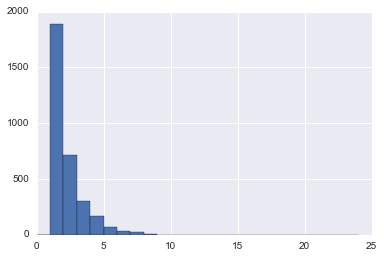

In [46]:
tf_disrupt.sum(axis=1).hist(bins=range(0, 25))

In [194]:
tf_disrupt.shape

(3225, 34)

In [ ]:
197673 - 8050

I want to look into how many motif disruptions I would get by chance when searching
this many motifs against this number of variants. There may be a few ways to do this,
though it is tricky. One idea is to randomly assign motifs instead of search the motifs
for the ChIP-seq peak that is overlapped. For instance, if a variant overlaps a JUN peak,
choose motifs for a random different TF. The problem here is that the motifs are correlated
(e.g. a different TF could still be enriched for a JUN motif) so sometimes you may
still expect a disruption. This motif similarity (which I explore some at the end of this
notebook) creates a lot of issues like this.

Another idea is to just look for motif disruptions among the variants that did not overlap
TF peaks. I intersected 197,673 variants with ChIP-seq peaks and found that 8,050 overlapped
a peak for at least one TF. I looked for motif disruptions for these 8,050 and found 3,225
disruptions. So I want to take the 197,673 - 8,050 and randomly choose sets of 8,050. Then
I'll randomly assign the same motifs I used for the real 8,050 and see how many motif disruptions
I get by chance. This will be a slightly biased estimate because some of the variants that did
not overlap peaks probably overlap a peak that was not assayed and may disrupt a motif that I'm 
searching give the motif similarity. I think I should still see a difference between the real and
randomly chosen variants though.

In [221]:
fn = os.path.join(outdir, 'num_disrupt_random.tsv')
if not os.path.exists(fn):
    # Note: for the code below to run, the IPcluster has to be set up
    # using some of the code above. If this doesn't work, you'll have
    # to scavenge the commands from above.
    random.seed('20160725')
    tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]

    d = {}
    for i in tf_overlap_yes.index:
        d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
    se = pd.Series(d)
    target_to_motif = pd.Series(motif_info.index, index=motif_info.target)

    random_mds = []
    for i in range(30):
        i = random.sample(tdf.index, tf_overlap_yes.shape[0])
        tdf_r = tdf.ix[i]
        tdf_r['motifs'] = se.apply(lambda x: list(target_to_motif[x])).values

        dview.push(dict(tdf_r=tdf_r));

        res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
                i, tdf_r.ix[i, 'ref'], tdf_r.ix[i, 'alt'], cpy.hg19, 
                {k:matrices[k] for k in tdf_r.ix[i, 'motifs']}), tdf_r.index)

        a = []
        b = []
        for i,p in enumerate(tdf_r.index):
            if res[i].shape[0] > 0:
                a.append(p)
                b.append(res[i])
        d = dict(zip(a,b))
        p = pd.Panel(d)
        motif_d_r = p.ix[:, :, 'score_diff'].T

        motif_disrupt_r = motif_d_r.abs() >= 2.5
        motif_disrupt_r = motif_disrupt_r[motif_disrupt_r.sum(axis=1) > 0]
        random_mds.append(motif_disrupt_r)

    num_disrupt_random = pd.Series([x.shape[0] for x in random_mds])
    num_disrupt_random.to_csv(fn, sep='\t')
else:
    num_disrupt_random = pd.read_table(fn, index_col=0, squeeze=True, header=None)
    
print('There were {} variants that disrupted motifs on average (s.d. {}, {} samples).'.format(
    num_disrupt_random.mean(), num_disrupt_random.std(), num_disrupt_random.shape[0]))

There were 2485.0 variants that disrupted motifs on average (s.d. 35.0280675636, 30 samples).


## CNV eQTLS

I'll mark which genes have an overlapping significant CNV.

In [48]:
t = pd.DataFrame(index=list(set(cnv_gv[cnv_gv.cnv_overlaps_gene].gene_id)))
t['cnv_eqtl'] = True
gene_variants = gene_variants.merge(t, how='outer', left_on='gene_id', right_index=True)
gene_variants.ix[gene_variants.cnv_eqtl.isnull(), 'cnv_eqtl'] = False

In [49]:
fn = os.path.join(outdir, 'gene_variants_annotated.pickle')
gene_variants.to_pickle(fn)

## Feature Exploration

In [50]:
n = gene_variants.shape[0]
print('{:,} total SNV and indel associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV and indels with significant associations.'.format(n))

255,393 total SNV and indel associations.
197,674 total distinct SNV and indels with significant associations.


In [52]:
n = len(set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} genes with a significant NMD variant.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id))
print('{:,} genes with a significant overlapping CNV.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id) |
        set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} total in these groups.'.format(n))

10 genes with a significant NMD variant.
88 genes with a significant overlapping CNV.
98 total in these groups.


In [53]:
gene_variants.variant_type.value_counts()

snv    227569
del     15294
ins     12508
Name: variant_type, dtype: int64

In [54]:
n = (gene_variants.gene_id.value_counts() > 1).value_counts()[False]
print('{:,} of {:,} genes have only one significant variant.'.format(n, len(set(gene_variants.gene_id))))

2,197 of 5,704 genes have only one significant variant.


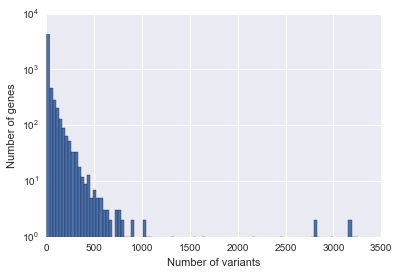

In [55]:
gene_variants.gene_id.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of variants');

In [56]:
gene_gb = gene_variants.groupby('gene_id')
num_genes = len(set(gene_variants.gene_id))

In [57]:
n = (gene_gb.exonic.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant exonic variant.'.format(
    n, num_genes))
m = (gene_gb.exonic_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own exon.'.format(
    m, n))

2,701 of 5,704 genes have at least one significant exonic variant.
2,016 of these 2,701 genes have at least one significant variant in their own exon.


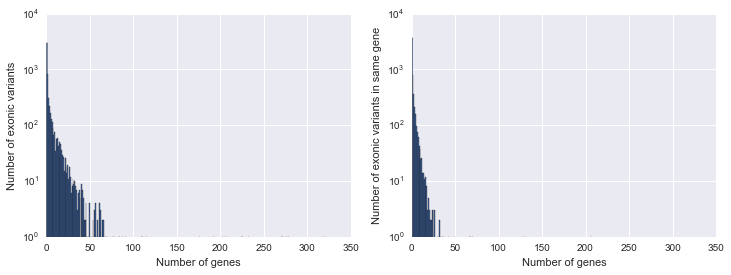

In [58]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.exonic.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[0])
ax.set_ylabel('Number of exonic variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.exonic_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[1])
ax.set_ylabel('Number of exonic variants in same gene')
ax.set_xlabel('Number of genes');

In [59]:
n = (gene_gb.utr.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant UTR variant.'.format(
    n, len(set(gene_variants.gene_id))))
m = (gene_gb.utr_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own UTR.'.format(
    m, n))

2,036 of 5,704 genes have at least one significant UTR variant.
1,319 of these 2,036 genes have at least one significant variant in their own UTR.


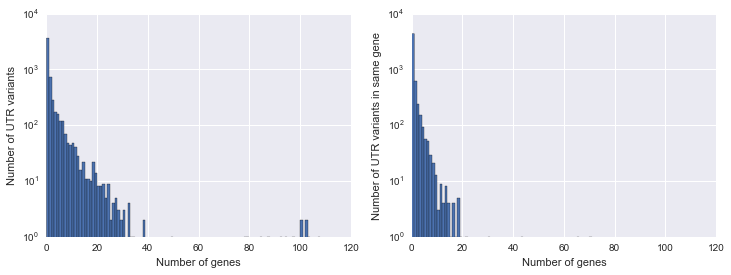

In [60]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.utr.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[0])
ax.set_ylabel('Number of UTR variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.utr_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[1])
ax.set_ylabel('Number of UTR variants in same gene')
ax.set_xlabel('Number of genes');

In [61]:
for c in [x for x in gene_variants.columns if 'dnase' in x]:
    vc = gene_variants[c].value_counts()
    print('{}\t{:.2f}%'.format(c, float(vc[True]) / vc.sum()))

iPS_DF_6.9_roadmap_dnase	0.05%
iPS_DF_19.11_roadmap_dnase	0.05%
H1_roadmap_dnase	0.04%
H9_roadmap_dnase	0.05%
iPSC_ENCSR000EKK_dnase	0.04%
iPSC_ENCSR000EKJ_dnase	0.04%
iPSC_ENCSR000EKI_dnase	0.05%
iPSC_ENCSR000EKH_dnase	0.02%
H7-hESC_ENCSR000EMZ_dnase	0.02%
H1-hESC_ENCSR000EMU_dnase	0.02%
H9_ENCSR000EJP_dnase	0.02%
H7-hESC_ENCSR000EJO_dnase	0.07%
H1-hESC_ENCSR000EJN_dnase	0.06%


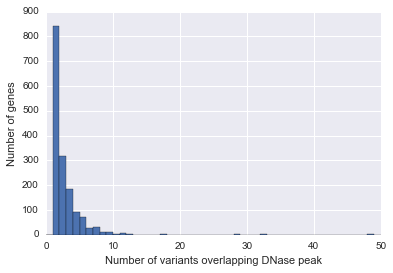

In [62]:
vc = gene_variants.ix[gene_variants['H1-hESC_ENCSR000EMU_dnase'] == True, 'gene_id'].value_counts()
vc.hist(bins=range(0, vc.max() + 1))
plt.ylabel('Number of genes')
plt.xlabel('Number of variants overlapping DNase peak');

In [63]:
gene_variants['significance.level_maurano'].value_counts()

not_imbalanced           12177
imbalanced_(5%_FDR)       2589
imbalanced_(0.1%_FDR)      290
Name: significance.level_maurano, dtype: int64

In [64]:
maurano_res['significance.level_maurano'].value_counts()

not_imbalanced           297687
imbalanced_(5%_FDR)       55141
imbalanced_(0.1%_FDR)      9456
Name: significance.level_maurano, dtype: int64

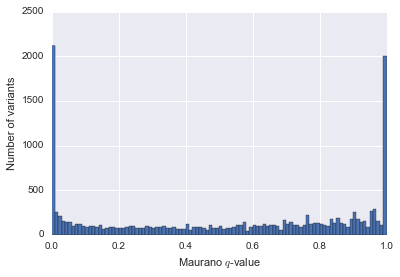

In [65]:
gene_variants['q.value_maurano'].hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $q$-value');

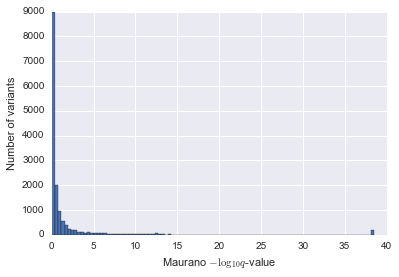

In [66]:
se = gene_variants['q.value_maurano'].dropna()
se += se[se > 0].min()
(-np.log10(se)).hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $-\log_{10}q$-value');

### Single variant genes

I'm going to look at genes for which there is only one significant
variant. In theory, these should often be the causal variants.

In [67]:
se = gene_variants.gene_id.value_counts() == 1
genes = set(se[se].index)
tdf = gene_variants[gene_variants.gene_id.apply(lambda x: x in genes)]

In [68]:
n = tdf.exonic.value_counts()[True]
print('{} of {} genes have an exonic variant.'.format(n, tdf.shape[0]))
n = tdf.utr.value_counts()[True]
print('{} of {} genes have a UTR variant.'.format(n, tdf.shape[0]))
n = tdf['H1-hESC_ENCSR000EMU_dnase'].value_counts()[True]
print('{} of {} genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.'.format(n, tdf.shape[0]))

313 of 2197 genes have an exonic variant.
163 of 2197 genes have a UTR variant.
114 of 2197 genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.


In [69]:
maurano_res['significance.level_maurano'].value_counts() / maurano_res.shape[0]

not_imbalanced           0.821695
imbalanced_(5%_FDR)      0.152204
imbalanced_(0.1%_FDR)    0.026101
Name: significance.level_maurano, dtype: float64

In [70]:
(gene_variants['significance.level_maurano'].value_counts() / 
 gene_variants['significance.level_maurano'].value_counts().sum())

not_imbalanced           0.808781
imbalanced_(5%_FDR)      0.171958
imbalanced_(0.1%_FDR)    0.019261
Name: significance.level_maurano, dtype: float64

In [71]:
tdf['significance.level_maurano'].value_counts() / tdf['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.748954
imbalanced_(5%_FDR)      0.230126
imbalanced_(0.1%_FDR)    0.020921
Name: significance.level_maurano, dtype: float64

In [72]:
tdf['significance.level_maurano'].value_counts()

not_imbalanced           179
imbalanced_(5%_FDR)       55
imbalanced_(0.1%_FDR)      5
Name: significance.level_maurano, dtype: int64

In [73]:
t = gene_variants.sort_values(by=['gene_id', 'pvalue'])
t = t.drop_duplicates(subset='gene_id')

In [74]:
t['significance.level_maurano'].value_counts() / t['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.718702
imbalanced_(5%_FDR)      0.258114
imbalanced_(0.1%_FDR)    0.023184
Name: significance.level_maurano, dtype: float64

In [75]:
n = len(set(tf_disrupt.index) & set(tdf.location))
print('The eQTL variant for {} genes disrupts a TF.'.format(n))
n = len(set(tf_disrupt.index) & set(tdf.location) & 
        set(tdf.ix[tdf['q.value_maurano'] < 0.05, 'location']))
print('{} of these are significant in Maurano et al.'.format(n))

The eQTL variant for 105 genes disrupts a TF.
19 of these are significant in Maurano et al.


## Fine Mapping

I'll start by removing genes are predicted to undergo NMD. I may also want to remove
genes where a CNV overlaps the gene.

In [76]:
n = qvalues.perm_sig.sum() - len(set(gene_variants.gene_id))
print('{} genes only had CNV associations.'.format(n))

42 genes only had CNV associations.


In [77]:
gene_variants_f = gene_variants[(gene_variants.gene_has_nmd_variant == False)]
a = len(set(gene_variants_f.gene_id))
b = len(set(gene_variants.gene_id))
print('{:,} of {:,} genes don\'t have a significant NMD variant.'.format(a, b))
print('{:,} genes have a significant NMD variant.'.format(b - a))

5,672 of 5,704 genes don't have a significant NMD variant.
32 genes have a significant NMD variant.


In [78]:
a = len(set(gene_variants_f.gene_id))
gene_variants_f = gene_variants_f[gene_variants_f.cnv_eqtl == False]
b = len(set(gene_variants_f.gene_id))
print('{:,} of {:,} genes don\'t have a significant overlapping CNV'.format(b, a))
print('{:,} genes have a significant overlapping CNV'.format(a - b))

5,606 of 5,672 genes don't have a significant overlapping CNV
66 genes have a significant overlapping CNV


In [79]:
n = qvalues.perm_sig.sum() - len(set(gene_variants_f.gene_id))
print('Removed {} genes due to CNV or NMD eQTLs.'.format(n))
print('{:,} remaining variants.'.format(len(set(gene_variants_f.location))))
print('{:,} remaining genes.'.format(len(set(gene_variants_f.gene_id))))

Removed 140 genes due to CNV or NMD eQTLs.
191,871 remaining variants.
5,606 remaining genes.


In [80]:
no_cnv_nmd_vars = gene_variants_f.location.drop_duplicates()
gene_variants_f.to_csv(os.path.join(outdir, 'no_cnv_nmd_vars_gv.tsv'), sep='\t')

In [81]:
a = peak_overlap.shape[1]
b = tf_overlap.shape[1]
print('Overlapped variants with {} ENCODE experiments for {} TFs.'.format(a, b))

Overlapped variants with 40 ENCODE experiments for 34 TFs.


In [82]:
n = sum(peak_overlap.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print(('{:,} of {:,} variants for {:,} eGenes overlapped at least one peak'.format(
            n, gene_variants_f.location.drop_duplicates().shape[0], 
            len(set(gene_variants_f[gene_variants_f.tf_overlap].gene_id)))))

7,840 of 191,871 variants for 2,244 eGenes overlapped at least one peak


In [83]:
n = sum(tf_disrupt.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print('{:,} of {:,} variants disrupted at least one TF.'.format(
        n, gene_variants_f.location.drop_duplicates().shape[0]))

3,140 of 191,871 variants disrupted at least one TF.


In [84]:
gene_variants_f = gene_variants_f[gene_variants_f.tf_disrupt]

In [85]:
len(set(gene_variants_f.gene_id))

1526

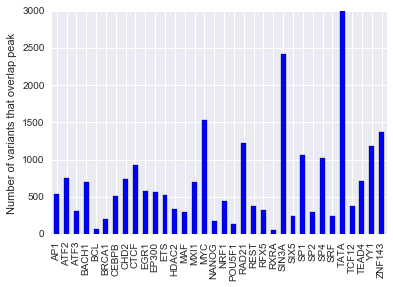

In [86]:
tf_overlap.sum().plot.bar()
plt.ylabel('Number of variants that overlap peak');

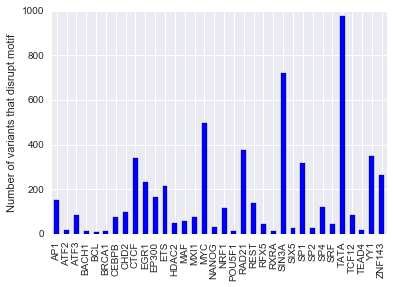

In [87]:
tf_disrupt.sum().plot.bar()
plt.ylabel('Number of variants that disrupt motif');

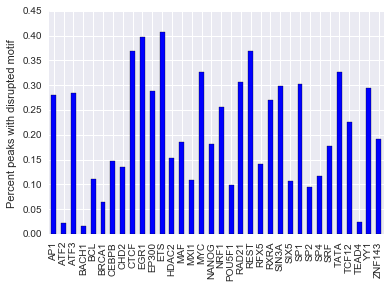

In [88]:
(tf_disrupt.sum() / tf_overlap.sum()).plot.bar()
plt.ylabel('Percent peaks with disrupted motif');

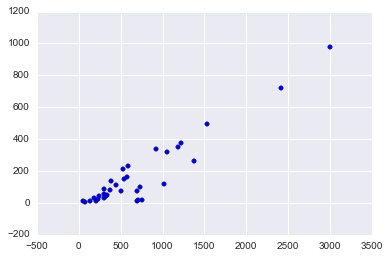

In [89]:
plt.scatter(tf_overlap.sum(), tf_disrupt.sum())

In [90]:
tf_disrupt['NANOG'].sum()

32

In [91]:
gene_variants_f['significance.level_maurano'].value_counts() / gene_variants_f['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.612960
imbalanced_(5%_FDR)      0.371278
imbalanced_(0.1%_FDR)    0.015762
Name: significance.level_maurano, dtype: float64

In [92]:
gene_variants['significance.level_maurano'].value_counts() / gene_variants['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.808781
imbalanced_(5%_FDR)      0.171958
imbalanced_(0.1%_FDR)    0.019261
Name: significance.level_maurano, dtype: float64

In [93]:
a = set(gene_variants_f.location) & set(maurano_res.index)
b = set(no_cnv_nmd_vars) & set(maurano_res.index)

print('Maurano assayed {:,} of the eQTL variants.'.format(len(a) + len(b)))
print ('{:.2f}% of all variants tested in Maurano paper were significant (q < 0.05).'.format(
    sum(maurano_res['q.value_maurano'] < 0.05) / float(maurano_res.shape[0]) * 100))
print('{:,} of {:,} ({:.2f}%) putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05), len(a),
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05) / float(len(a)) * 100))
print('{:,} of {:,} ({:.2f}%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05), len(b),
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05) / float(len(b)) * 100))

Maurano assayed 13,664 of the eQTL variants.
17.83% of all variants tested in Maurano paper were significant (q < 0.05).
373 of 992 (37.60%) putative eQTNs were significant in Maurano (q < 0.05).
2,430 of 12,672 (19.18%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).


In [94]:
pe_sig = sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05)
pe_not_sig = len(a) - pe_sig
not_pe_sig = sum(maurano_res['q.value_maurano'] < 0.05)
not_pe_not_sig = maurano_res.shape[0] - not_pe_sig
odds, p = stats.fisher_exact([[pe_sig, pe_not_sig], [not_pe_sig, not_pe_not_sig]])
print('peQTNs enriched for altering TF binding relative to all Maurano variants '
      '(odds={:.4f}, p={:.4e}, Fisher).'.format(odds, p))

pe_sig = sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05)
pe_not_sig = len(a) - pe_sig
not_pe_sig = sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05)
not_pe_not_sig = len(b) - not_pe_sig
odds, p = stats.fisher_exact([[pe_sig, pe_not_sig], [not_pe_sig, not_pe_not_sig]])
print('peQTNs enriched for altering TF binding relative to non-peQTN eQTL variants '
      '(odds={:.4f}, p={:.4e}, Fisher).'.format(odds, p))

peQTNs enriched for altering TF binding relative to all Maurano variants (odds=2.7776, p=1.2216e-48, Fisher).
peQTNs enriched for altering TF binding relative to non-peQTN eQTL variants (odds=2.5398, p=4.4460e-38, Fisher).


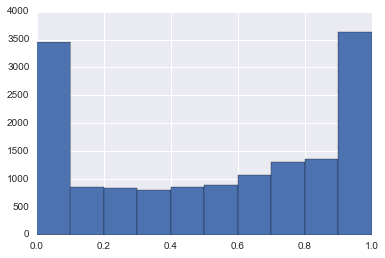

In [95]:
gene_variants['q.value_maurano'].hist()

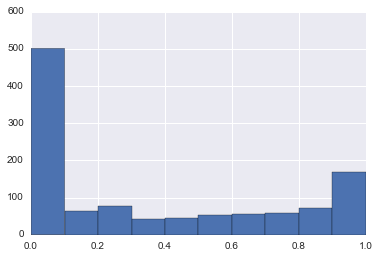

In [96]:
gene_variants_f['q.value_maurano'].hist()

In [97]:
n = len(set(gene_variants_f.gene_id))
a = sum(gene_variants_f.gene_id.value_counts() == 1)
print('{:,} of {:,} ({:.2f}%) eGenes have one putative eQTN.'.format(a, n, a / float(n) * 100))
a = sum(gene_variants_f.gene_id.value_counts() <= 5)
print('{:,} of {:,} ({:.2f}%) eGenes have five or less putative eQTNs.'.format(a, n, a / float(n) * 100))

766 of 1,526 (50.20%) eGenes have one putative eQTN.
1,404 of 1,526 (92.01%) eGenes have five or less putative eQTNs.


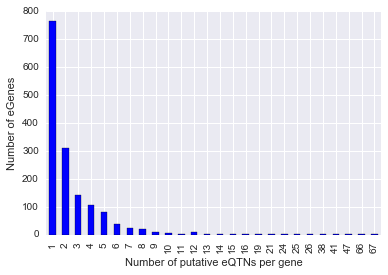

In [98]:
vc = gene_variants_f.gene_id.value_counts().value_counts().sort_index()
vc.plot(kind='bar')
plt.ylabel('Number of eGenes')
plt.xlabel('Number of putative eQTNs per gene');

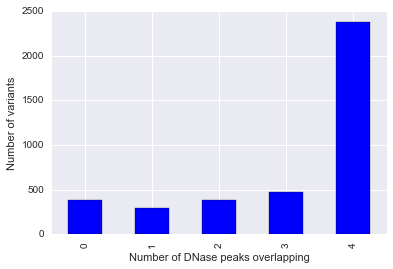

In [99]:
gene_variants_f['roadmap_dnase_num'] = \
    gene_variants_f[[x for x in gene_variants_f.columns 
                    if '_roadmap_dnase' in x]].sum(axis=1)

se = gene_variants_f.roadmap_dnase_num.value_counts()
se = se[range(se.shape[0])]
se.plot(kind='bar')
plt.ylabel('Number of variants')
plt.xlabel('Number of DNase peaks overlapping');

In [100]:
a = gene_variants_f[gene_variants_f.roadmap_dnase_num > 0].drop_duplicates(subset='location').shape[0]
b = gene_variants_f.drop_duplicates(subset='location').shape[0]
print('{:,} of {:,} ({:.2f}%) putative eQTNs overlap a DHS.'.format(a, b, a / float(b) * 100))
a = gene_variants_f[gene_variants_f.roadmap_dnase_num == 4].drop_duplicates(subset='location').shape[0]
b = gene_variants_f.drop_duplicates(subset='location').shape[0]
print('{:,} of {:,} ({:.2f}%) putative eQTNs overlap DHS present in all four lines.'.format(a, b, a / float(b) * 100))

2,835 of 3,140 (90.29%) putative eQTNs overlap a DHS.
1,923 of 3,140 (61.24%) putative eQTNs overlap DHS present in all four lines.


[Wen et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005176) says 50% of cis-eQTLs are concentrated within 20kb of the TSS.

In [101]:
n = sum(gene_variants_f.tss_dist_abs < 20000)
p = float(n) / gene_variants_f.shape[0]
print('{:,} of {:,} ({:.1f}%) putative causal variants are within 20kb of the nearest TSS.'.format(
        n, gene_variants_f.shape[0], p * 100))

2,106 of 3,905 (53.9%) putative causal variants are within 20kb of the nearest TSS.


In [102]:
lead_variants_single_f.head()

,chrom,start,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,gene_type,AF,EUR_AF,SAS_AF,AFR_AF,AMR_AF,EAS_AF,perm_pvalue,perm_qvalue,perm_sig
chr1:169862063-169862064:ENSG00000000460.12,chr1,169862063,169862064,1:169862064_C/G_rs12131357,215,35,1,182/31/2,0.08140,5.4640,...,protein_coding,0.084066,0.1044,0.0716,0.1505,0.0548,0.0089,0.000100,0.000253,True
chr6:46112388-46112389:ENSG00000001561.6,chr6,46112388,46112389,6:46112389_A/G_rs1048077,215,290,1,27/86/102,0.32558,8.3460,...,protein_coding,0.821885,0.6809,0.7935,0.9607,0.7954,0.8264,0.000100,0.000253,True
chr12:1056029-1056030:ENSG00000002016.12,chr12,1056029,1056030,12:1056030_C/G_rs12822733,215,63,1,157/53/5,0.14651,-5.8603,...,protein_coding,0.172324,0.1879,0.2311,0.1732,0.1182,0.1359,0.000100,0.000253,True
chr12:9095748-9095749:ENSG00000003056.3,chr12,9095748,9095749,12:9095749_T/C_rs7309922,215,199,1,69/93/53,0.46279,-8.2255,...,protein_coding,0.358027,0.4473,0.4796,0.1536,0.3905,0.3968,0.000100,0.000253,True
chr7:9247738-9247739:ENSG00000003147.13,chr7,9247738,9247739,7:9247739_A/G_rs12537168,215,129,1,104/93/18,0.30000,-4.6270,...,protein_coding,0.188299,0.3032,0.2464,0.0189,0.1816,0.2440,0.011628,0.017456,True


In [103]:
n = len(set(gene_variants_f.location + ':' + gene_variants_f.gene_id) & set(lead_variants_single_f.index))
print('{:,} of my {:,} putative causal variants ({:.2f}%)  are also the most significant variants'.format(
        n, gene_variants_f.shape[0], float(n) / gene_variants_f.shape[0] * 100))
a = len(set(gene_variants_f.gene_id))
print('The lead variant is a peQTN for {:,} of {:,} ({:.2f}%) genes with peQTNs.'.format(n, a, n / float(a) * 100))

298 of my 3,905 putative causal variants (7.63%)  are also the most significant variants
The lead variant is a peQTN for 298 of 1,526 (19.53%) genes with peQTNs.


In [104]:
gene_variants_f.index = gene_variants_f.location + ':' + gene_variants_f.gene_id

In [105]:
gene_variants_f.to_csv(os.path.join(outdir, 'peqtns.tsv'), sep='\t')

### $p$-value comparison

In [106]:
leads_p = lead_variants_single_f[lead_variants_single_f.gene_id.apply(lambda x: x in set(gene_variants_f.gene_id))]

In [107]:
gvf_p = gene_variants_f.sort_values(by='pvalue').drop_duplicates(subset='gene_id')

In [108]:
leads_p.sort_values(by='gene_id', inplace=True)
gvf_p.sort_values(by='gene_id', inplace=True)

In [109]:
pvals = pd.DataFrame({'qtn':gvf_p.pvalue.values, 'lead':leads_p.pvalue.values},
                    index=gvf_p.gene_id)
pvals_log = -np.log10(pvals)

pvals_log['secondary'] = False
pvals_log.ix[set(secondary_qvalues[secondary_qvalues.perm_sig].index) & set(pvals_log.index),
            'secondary'] = True

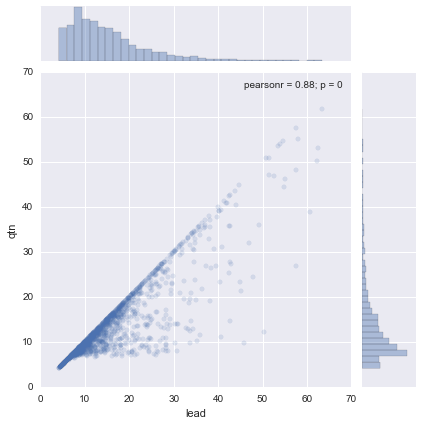

In [110]:
sns.jointplot(pvals_log.lead, pvals_log.qtn, kind='scatter', alpha=0.15);

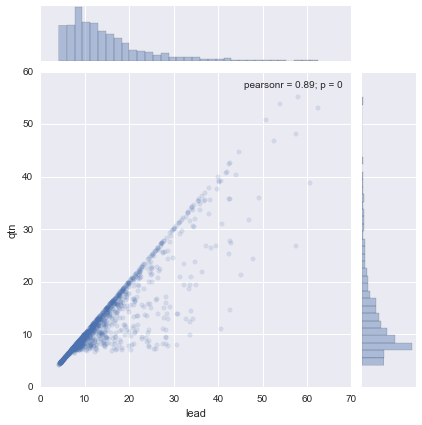

In [111]:
sns.jointplot(pvals_log[pvals_log.secondary == False].lead, 
              pvals_log[pvals_log.secondary == False].qtn, kind='scatter', alpha=0.15);

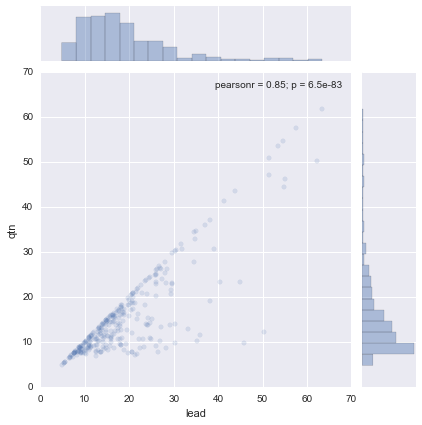

In [112]:
sns.jointplot(pvals_log[pvals_log.secondary].lead, 
              pvals_log[pvals_log.secondary].qtn, kind='scatter', alpha=0.15);

In [113]:
pvals_log['pdiff'] = pvals_log.lead - pvals_log.qtn

In [114]:
diff_sec = pvals_log[pvals_log.secondary & (pvals_log.pdiff > 1)].shape[0]
no_diff_sec = pvals_log[pvals_log.secondary & (pvals_log.pdiff <= 1)].shape[0]
diff_no_sec = pvals_log[(pvals_log.secondary == False) & (pvals_log.pdiff > 1)].shape[0]
no_diff_no_sec = pvals_log[(pvals_log.secondary == False) & (pvals_log.pdiff <= 1)].shape[0]
s,p = stats.fisher_exact([[diff_sec, no_diff_sec], [diff_no_sec, no_diff_no_sec]])
print('eGenes with secondary eQTLs are enriched for having their peQTN differ in significance '
      'from the lead (p={:.2e})'.format(p))

eGenes with secondary eQTLs are enriched for having their peQTN differ in significance from the lead (p=2.53e-12)


In [115]:
a = sum(pvals_log.pdiff < 1)
b = pvals_log.shape[0]
print('For {:,} of {:,} ({:.2f}%) genes with peQTNs, the peQTN p-value is within one '
      'order of magnitude of the lead.'.format(a, b, a / float(b) * 100))

For 928 of 1,526 (60.81%) genes with peQTNs, the peQTN p-value is within one order of magnitude of the lead.


In [116]:
a = sum(pvals_log.pdiff < 2)
b = pvals_log.shape[0]
print('For {:,} of {:,} ({:.2f}%) genes with peQTNs, the peQTN p-value is within two '
      'orders of magnitude of the lead.'.format(a, b, a / float(b) * 100))

For 1,107 of 1,526 (72.54%) genes with peQTNs, the peQTN p-value is within two orders of magnitude of the lead.


### 3D interactions

In [117]:
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 'interactions.tsv')
interactions = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 
                  'gene_to_containing_interactions.pickle')
gene_to_containing_interactions = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_exon_gene.pickle')
chia_to_exon_gene = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_promoter_gene.pickle')
chia_to_promoter_gene = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_peaks.bed')
chia_peaks = pbt.BedTool(fn)

In [118]:
s = '\n'.join(gene_variants_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
gene_variants_f = gene_variants_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                      left_on='location', right_index=True, how='left')

In [119]:
s = '\n'.join(lead_variants_single_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
lead_variants_single_f = lead_variants_single_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                                  left_on='location', right_index=True, how='left')

In [120]:
def get_other_end(peaks):
    if type(peaks) is set:
        other_ends = []
        for p in peaks:
            other_ends += list(interactions.ix[interactions.peak1 == p, 'peak2'])
            other_ends += list(interactions.ix[interactions.peak2 == p, 'peak1'])
        return set(other_ends)
    else:
        return np.nan
    
def get_promoter_gene(peaks):
    if type(peaks) is set:
        peaks = peaks & set(chia_to_promoter_gene.index)
        genes = []
        for p in peaks:
            genes += list(chia_to_promoter_gene[p])
        out = set(genes)
        if len(out) == 0:
            return np.nan
        else:
            return out
    else:
        return np.nan

In [121]:
gene_variants_f['chia_interaction_peak'] = gene_variants_f.chia_peaks.apply(lambda x: get_other_end(x))
lead_variants_single_f['chia_interaction_peak'] = lead_variants_single_f.chia_peaks.apply(lambda x: get_other_end(x))

In [122]:
gene_variants_f['chia_interaction_promoter_gene'] = \
    gene_variants_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))
lead_variants_single_f['chia_interaction_promoter_gene'] = \
    lead_variants_single_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))

In [123]:
gene_variants_f['interacts_with_promoter'] = np.nan
t = gene_variants_f[gene_variants_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
gene_variants_f.ix[se.index, 'interacts_with_promoter'] = se

In [124]:
lead_variants_single_f['interacts_with_promoter'] = np.nan
t = lead_variants_single_f[lead_variants_single_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
lead_variants_single_f.ix[se.index, 'interacts_with_promoter'] = se

In [125]:
shared = set(lead_variants_single_f.index) & set(gene_variants_f.index)

In [126]:
a = lead_variants_single_f.interacts_with_promoter.sum()
b = gene_variants_f.interacts_with_promoter.sum()
c = len(set(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].index) 
        & set(gene_variants_f[gene_variants_f.interacts_with_promoter == True].index))
print('{} lead variants and {} putative eQTNs ({} shared) '
      'interact with promoters.'.format(a, b, c))

71 lead variants and 154 putative eQTNs (19 shared) interact with promoters.


In [127]:
lead_interact = lead_variants_single_f.drop(shared).interacts_with_promoter.sum()
lead_no_interact = lead_variants_single_f.drop(shared).shape[0] - lead_interact
put_interact = gene_variants_f.drop(shared).interacts_with_promoter.sum()
put_no_interact = gene_variants_f.drop(shared).shape[0] - put_interact
stats.fisher_exact([[put_interact, put_no_interact], [lead_interact, lead_no_interact]])

(4.0348059198865647, 1.9501785416492163e-19)

In [128]:
sum(gene_variants_f[gene_variants_f.interacts_with_promoter == True].tss_dist_abs > 20000)

46

In [129]:
sum(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].tss_dist_abs > 20000)

13

In [130]:
sum(gene_variants_f.tss_dist_abs > 20000)

1799

### Motif Similarity

In [131]:
s = cpb.general.read_gzipped_text_url('http://compbio.mit.edu/encode-motifs/motifs-sim.txt.gz')
lines = s.strip().split('\n')
lines = [x.split('\t') for x in lines]
vals = [x[1:] for x in lines[1:]]
index = [x[0] for x in lines][1:]
header = lines[0][1:]
motif_sim = pd.DataFrame(vals, index=index, columns=header)
motif_sim = motif_sim.astype(float)

In [132]:
t = motif_sim.ix[motif_info.index, motif_info.index]

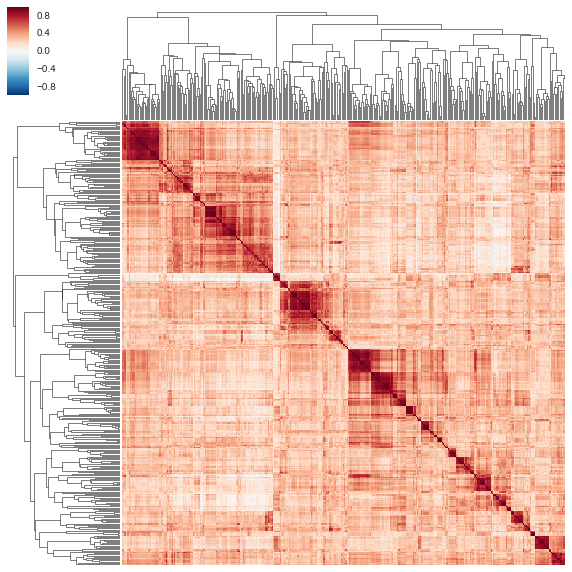

In [133]:
sns.clustermap(t, xticklabels=[], yticklabels=[]);

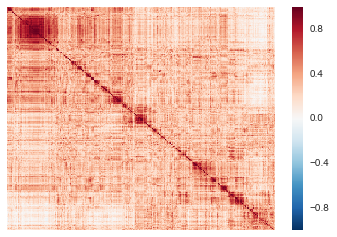

In [134]:
sns.heatmap(motif_sim, xticklabels=[], yticklabels=[]);

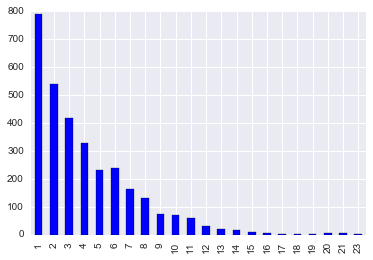

In [135]:
tf_overlap.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1).value_counts().sort_index().plot(kind='bar')

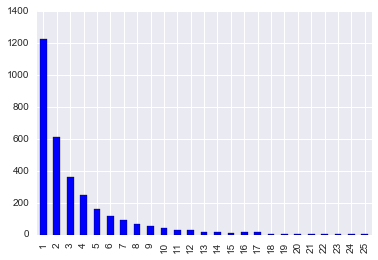

In [136]:
motif_disrupt.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1).value_counts().sort_index().plot(kind='bar')

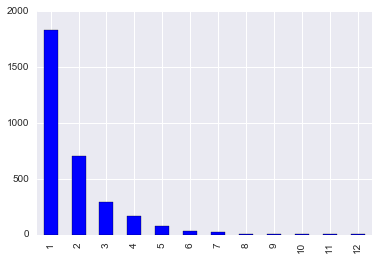

In [137]:
num_tf_motifs = []
for i in gene_variants_f.location.drop_duplicates():
    se = motif_disrupt.ix[i]
    num_tf_motifs.append(len(set([x.split('_')[0] for x in se[se].index])))
pd.Series(num_tf_motifs).value_counts().sort_index().plot(kind='bar')

In [138]:
for i in gene_variants_f.location.drop_duplicates()[0:5]:
    se = motif_disrupt.ix[i]
    df = motif_sim.ix[se[se].index]
    df = df > 0.75
    print('Disrupts motifs: {}'.format(', '.join(list(se[se].index))))
    print('These motifs are similar to known motifs for: {}'.format(
            ', '.join(list(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x])))))
    print('These TFs are not expected: {}'.format(
        ', '.join(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x]) - 
                              set([x.split('_')[0] for x in se[se].index]))))
    print('----------------------------------------------------------------------------------------------------')

Disrupts motifs: YY1_disc5
These motifs are similar to known motifs for: 
These TFs are not expected: 
----------------------------------------------------------------------------------------------------
Disrupts motifs: SP1_known1
These motifs are similar to known motifs for: SP8, KLF12, KLF16, CACD, SP1, KLF14, CACBP, KLF7, SP4, KLF4, PATZ1, TEAD2
These TFs are not expected: SP8, KLF12, KLF16, KLF14, SP4, CACBP, KLF7, CACD, KLF4, TEAD2, PATZ1
----------------------------------------------------------------------------------------------------
Disrupts motifs: CHD2_disc3, SP1_disc3, SP1_known2, SP1_known5, SP1_known6, SP1_known7, SP1_known8, TATA_disc7, ZNF143_disc3
These motifs are similar to known motifs for: SP8, WT1, ZNF219, KLF13, KLF16, ETV6, MAZ, SP1, EGR1, SP4, KLF12, KLF7, ZNF740, CACD, KLF4, TEAD2, CACBP, PATZ1, HF1H3B, KLF14, ZNF281
These TFs are not expected: SP8, WT1, CACBP, EGR1, KLF16, ZNF740, ETV6, SP4, MAZ, ZNF219, KLF4, KLF7, KLF12, CACD, KLF13, PATZ1, TEAD2, HF1H3B, 

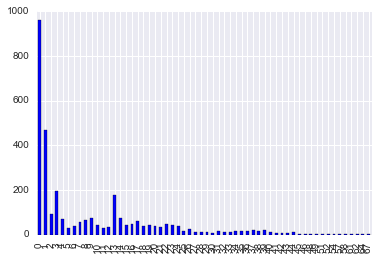

In [139]:
num_sim_motifs = []
for i in gene_variants_f.location.drop_duplicates():
    se = motif_disrupt.ix[i]
    df = motif_sim.ix[se[se].index]
    df = df > 0.75
    num_sim_motifs.append(len(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x]) - 
                              set([x.split('_')[0] for x in se[se].index])))

pd.Series(num_sim_motifs).value_counts().sort_index().plot(kind='bar')

In [140]:
a = sum(pd.Series(num_sim_motifs) > 0)
b = len(num_sim_motifs)
print('{:,} of {:,} ({:.2f}%) peQTNs disrupt a motif that is '
      'similar to a known motif for a different TF (e.g. the variant '
      'does not overlap a peak for the other TF)'.format(a, b, a / float(b) * 100))

2,178 of 3,140 (69.36%) peQTNs disrupt a motif that is similar to a known motif for a different TF (e.g. the variant does not overlap a peak for the other TF)


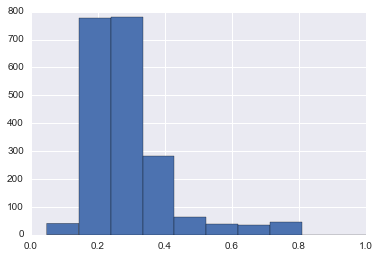

In [141]:
motif_sim.ix['ETV6_1'].hist()